# PyFlowDensityCalc
Расчет функции приведенной плотности потока массы от приведенной скорости. Построение графиков, вывод значений полученных в результате расчета.

## Требуется получить:
1. График функции приведенной плотности потока массы от приведенной скорости с использованием языка программирования python. 
2. Экспортировать полученный график в png.
3. Вывести значения полученные в результате расчетов в xlsx и csv форматы для возможного последующего использования.

## Решение:
Решение приведено в формате Jupyter Notebook "**main.ipynb**" для удобного запуска в облачных системах типа Google Colab или на персональных компьютерах. 
Для запуска кода блокнота Jupyter Notebook в облачной системе Google Colab нужно перейти по ссылке:
https://colab.research.google.com/github/mikiway902/PyFlowDensityCalc/blob/main/main.ipynb

В файле кода языка python "**MainCode.py**" содержащем код программы.

Код выполнен с использованием основных библиотек **torch** (PyTorch), **matplotlib**, **pandas**, **openpyxl**, **os**. 

Инновационность подхода данного решения от остальных заключается в использовании библиотеки PyTorch для работы с матричными вычислениями для ускорения вычислений, что ускоряет расчет.

Расчет вычислений с матрицами позволяет не использоваться циклы и проводить расчет сразу для всех возможных показателей адиабаты k по всем значениям приведенной скорости лямбда.

Так же основным отличием от остальных фреймворков / библиотек, используемых для работы с данными PyTorch отличает возможность работы на графическом процессоре (*GPU*) с использованием ядер CUDA, что ускоряет вычисления вполть до **10 раз**.

Библиотека mathplotlib была использована для создания и сохранения графиков по полученным в результате расчета значениям в формате **PNG**.

Библиотека pandas была использована для сохранения данных в табличном **CSV** формате, а openpyxl для их сохранения в формате **XLSX**.

Так же были использованы второстепенные библиотеки для автоматической установки зависимостей (библиотек): **importlib**, **subprocess**, **sys**.

Все данные, полученные в результате вычислений, сохраняются в папку **Results**.

## Установка библиотек для задания. Позволяет не переустанавливать библиотеки заново, если уже они были установлены в виртуальном окружении.

In [7]:
import importlib.util
import subprocess
import sys

def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])

for pkg in ["torch", "matplotlib", "pandas", "openpyxl"]:
    install_if_missing(pkg)


## Формула приведенной плотности потока массы от приведенной скорости.

$$
q(\lambda) = \left(\frac{k+1}{2}\right)^{\frac{1}{k-1}} \lambda \left(1 - \frac{k-1}{k+1} \lambda^2\right)^{\frac{1}{k-1}}
$$

## Код проекта на языке python с использованием PyTorch, matplotlib, pandas, os, openpyxl.

Cuda is not using
Cuda is not using
✅ Результаты сохранены в папку: c:\Users\sladk\Desktop\ЦИАМ\Попытка №2\Results


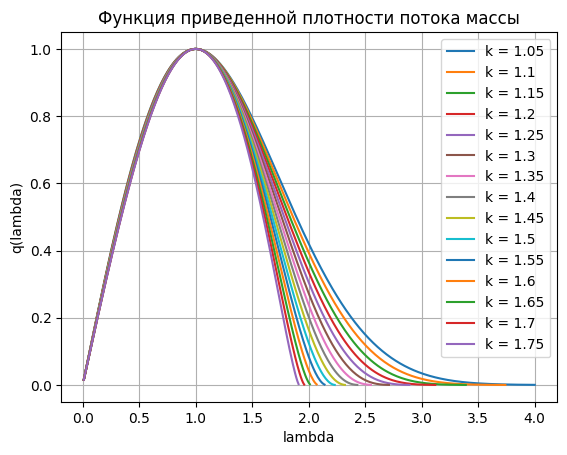

📈 График сохранён: c:\Users\sladk\Desktop\ЦИАМ\Попытка №2\Results\plot.png


In [8]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import os

# Функция ввода данных для расчета

def input_nums_func():
    in_nums = input('Введите 0, если использовать стандартные значения. 1, если нужно задать свои: ')
    if in_nums == '1':
        k_0 = float(input('Введите начальное значение показателя изоэнтропы: '))
        k_last = float(input('Введите последнее значение показателя изоэнтропы: '))
        k_decr = float(input('Введите шаг значения показателя изоэнтропы: '))
        accuracy_k = int(input('Введите количество знаков после запятой показателя изоэнтропы: '))
        lambda_0 = float(input('Введите начальное значение приведенной скорости: '))
        lambda_last = float(input('Введите последнее значение приведенной скорости: '))
        lambda_decr = float(input('Введите шаг значения приведенной скорости: '))
        accuracy_l = int(input('Введите количество знаков после запятой приведенной скорости: '))
    else:
        k_0 = 1.05
        k_last = 1.75
        k_decr = 0.05
        accuracy_k = 100
        lambda_0 = 0.01
        lambda_last = 4.00
        lambda_decr = 0.01
        accuracy_l = 100
        
    return(k_0, k_last, k_decr, accuracy_k, lambda_0, lambda_last, lambda_decr, accuracy_l)

# Функция подсчета количества шагов для построения графика

def steps_calc_func(k_0, k_last, k_decr, accuracy_k, lambda_0, lambda_last, lambda_decr, accuracy_l):
    k_steps = int(((int(k_last*accuracy_k) - int(k_0*accuracy_k)) / int(k_decr*accuracy_k))+1)
    lambda_steps = int(((int(lambda_last*accuracy_l) - int(lambda_0*accuracy_l)) / int(lambda_decr*accuracy_l))+1)
    return(k_steps, lambda_steps)

# Функция создание единичных тензоров (матриц) подсчитанного размера

def tensor_zeros_create(k_steps, lambda_steps, device="cpu"):
    lambda_var = torch.ones(k_steps, lambda_steps, device=device)
    k_var = torch.ones(k_steps, lambda_steps, device=device)
    density = torch.ones(k_steps, lambda_steps, device=device)
    return(lambda_var, k_var, density)

"""
Функция переноса вычислений тезоров (матриц) с вычисления на CPU (центральном процессоре) на GPU (графический ускоритель),
позволяет производить те же самые вычисления с большей скоростью ввиду большей приспособленности GPU к матричным вычислениям.
"""

def cuda_calc_transfer_func(lambda_var, k_var, density, GPU_usage):
    if GPU_usage == 0:
        if torch.cuda.is_available():
            lambda_var = lambda_var.cuda()
            k_var = k_var.cuda()
            density = density.cuda()
            print("Cuda is using")
            GPU_usage = 1
        else:
            print("Cuda is not using")
    elif GPU_usage == 1:
        lambda_var = lambda_var.cpu()
        k_var = k_var.cpu()
        density = density.cpu()
        GPU_usage = 0
        print("Calculated data returned to CPU")
    return(lambda_var, k_var, density, GPU_usage)

# Функция, заполняющая тензор (матрицу) значениями по оси ординат (к). Перебор всех значени показателя адиабаты.

def k_var_filling(k_var, k_0, k_last, k_steps):
    device = k_var.device
    k_range = torch.linspace(k_0, k_last, steps=k_steps, device=device).reshape(-1, 1)
    k_var = k_var * k_range
    return k_var

# Функция, заполняющая тензор (матрицу) значениями по оси ординат (лямбда). Перебор всех значений приведенной скорости.

def lambda_var_filling(lambda_var, lambda_0, lambda_last, lambda_steps):
    device = lambda_var.device
    lambda_range = torch.linspace(lambda_0, lambda_last, steps=lambda_steps, device=device)
    lambda_var = lambda_var * lambda_range
    return lambda_var

"""
Функция, производящая вычисления между тензорами (матрицами) по формуле функции приведенной плотности потока
массы от приведенной скорости. 
"""
def calculations_func(k_0, k_last, k_decr, accuracy_k, lambda_0, lambda_last, lambda_decr, accuracy_l):
    GPU_usage = 0
    
    k_steps, lambda_steps = steps_calc_func(k_0, k_last, k_decr, accuracy_k, lambda_0, lambda_last, lambda_decr, accuracy_l)
    lambda_var, k_var, density = tensor_zeros_create(k_steps, lambda_steps)
    lambda_var, k_var, density, GPU_usage = cuda_calc_transfer_func(lambda_var, k_var, density, GPU_usage)
    
    k_var = k_var_filling(k_var, k_0, k_last, k_steps)
    lambda_var = lambda_var_filling(lambda_var, lambda_0, lambda_last, lambda_steps)
    
    density = density * ((k_var+1)/2)**(1/(k_var-1))*lambda_var*((1-(k_var-1)/(k_var+1)*(lambda_var)**2)**(1/(k_var-1)))
    
    lambda_var, k_var, density, GPU_usage = cuda_calc_transfer_func(lambda_var, k_var, density, GPU_usage)
    return(density, lambda_var, k_var)

# Функция фильтрации значений меньше или близких нуля, ввиду их малости.
    
def filter_func(density):
    threshold = 1e-4
    mask_small = density <= threshold
    indices = torch.where(mask_small.any(1), mask_small.float().argmax(1), density.shape[1])
    nan_mask = torch.arange(density.shape[1])[None, :] >= indices[:, None]
    density[nan_mask] = float('nan')
    return(density)

# Функция сохранения полученных данных в результате расчета в форматы CSV и XLSX.

def save_to_csv(density, lambda_var):
    try:
        script_dir = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        script_dir = os.getcwd()
    
    # Создаём папку Results
    results_dir = os.path.join(script_dir, "Results")
    os.makedirs(results_dir, exist_ok=True)

    # Пути для сохранения
    excel_path = os.path.join(results_dir, "results.xlsx")
    csv_density_path = os.path.join(results_dir, "density.csv")
    csv_lambda_path = os.path.join(results_dir, "lambda_var.csv")

    df_density = pd.DataFrame(density.detach().cpu().numpy())
    df_lambda = pd.DataFrame(lambda_var.detach().cpu().numpy())

    df_density.to_csv(csv_density_path, index=False, header=False)
    df_lambda.to_csv(csv_lambda_path, index=False, header=False)

    with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
        df_density.to_excel(writer, sheet_name="density", index=False, header=False)
        df_lambda.to_excel(writer, sheet_name="lambda_var", index=False, header=False)
    
    print(f"✅ Результаты сохранены в папку: {results_dir}")

# Функция создания графика в PNG формате по полученным значениям.

def graphics_create_func(density, lambda_var, k_var):
    try:
        script_dir = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        script_dir = os.getcwd()
    
    results_dir = os.path.join(script_dir, "Results")
    os.makedirs(results_dir, exist_ok=True)
    png_path = os.path.join(results_dir, "plot.png")

    plt.grid(True)
    density = density.detach().cpu().numpy()
    lambda_var = lambda_var.detach().cpu().numpy()
    k_var = k_var.detach().cpu().numpy()

    for i in range(lambda_var.shape[0]):
        functionlabel = 'k = ' + str(round(k_var[i, 0], 3))
        plt.plot(lambda_var[i], density[i], label=functionlabel)

    plt.title('Функция приведенной плотности потока массы')
    plt.xlabel('lambda')
    plt.ylabel('q(lambda)')
    plt.legend(loc="upper right")
    plt.savefig(png_path, dpi=600, bbox_inches='tight')
    plt.show()
    print(f"📈 График сохранён: {png_path}")

# Основная функция, объединяющая все функции.

def main():
    k_0, k_last, k_decr, accuracy_k, lambda_0, lambda_last, lambda_decr, accuracy_l = input_nums_func()
    density, lambda_var, k_var = calculations_func(k_0, k_last, k_decr, accuracy_k, lambda_0, lambda_last, lambda_decr, accuracy_l)
    density = filter_func(density)
    save_to_csv(density, lambda_var)
    graphics_create_func(density, lambda_var, k_var)



if __name__ == "__main__":
    main()
